`Problem: This lab session focuses on the problem of weather prediction using RNNs based on a time-series dataset consisting of 500 daily weather records. Each record includes the date, temperature (°C), humidity (%), and rainfall (mm). The core problem is to model the temporal dependency among these variables in order to predict future weather conditions, particularly temperature, using past observations. Traditional feedforward models are inadequate for this task because they do not retain historical context. Therefore, an RNN-based approach is required to learn sequential patterns, seasonal variations, and short-term dependencies inherent in weather data. The challenge lies in achieving accurate predictions with a relatively small dataset while handling variability, noise, and non-linear relationships among weather parameters.`

`Step 1: Import Required Libraries`

In [100]:
import pandas as pd

`Step 2: Load the Weather Dataset`

In [101]:
data=pd.read_csv("weather.csv")

`Dataset descriptions:`

In [102]:
data.head()

,Date,Temperature,Humidity,Rainfall
0,2023-01-01,24.5,64.6,8.6
1,2023-01-02,24.2,70.1,6.7
2,2023-01-03,25.3,54.1,3.2
3,2023-01-04,26.4,64.5,0.4
4,2023-01-05,25.0,59.0,5.8


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         500 non-null    object 
 1   Temperature  500 non-null    float64
 2   Humidity     500 non-null    float64
 3   Rainfall     500 non-null    float64
dtypes: float64(3), object(1)
memory usage: 15.8+ KB


In [104]:
data.isnull().sum()

,0
Date,0
Temperature,0
Humidity,0
Rainfall,0


`Step 3: Select Features`

In [147]:
#We use Temperature, Humidity, Rainfall (multivariate RNN).
#features = data[["Temperature", "Humidity", "Rainfall"]].values

* `Important note:`
* `How we select features and target variables`
     *  doing multivariate RNN for weather prediction, the way you select features and target is critical.

`1. Understand your data`

| Date       | Temperature | Humidity | Rainfall |
| ---------- | ----------- | -------- | -------- |
| 2025-01-01 | 25          | 70       | 5        |
| 2025-01-02 | 26          | 65       | 0        |
| ...        | ...         | ...      | ...      |


* `There are 3 features: Temperature, Humidity, Rainfall.`
     * Usually, your target variable is what you want to predict.
     * `For example:`
         * Predict Temperature tomorrow → Temperature is target, Humidity and Rainfall can be features.
         * Predict all three tomorrow → multivariate output; target = [Temperature, Humidity, Rainfall].

`2. Define features (X) and target (y)`

`Suppose you want to predict Temperature:`

      * `Features: all columns except 'Temperature`
          * X = data[['Humidity', 'Rainfall']].values  
      *  `Target: Temperature`
          * y = data['Temperature'].values

`* For multivariate output (predict all three), then:`
* `Features: all columns`
     * X = data[['Temperature', 'Humidity', 'Rainfall']].values
*  `Target: all columns shifted by 1 day`
     * y = X[1:]           # next day's values
     * X = X[:-1]          # current day's values

In [148]:
X = data[['Temperature', 'Humidity', 'Rainfall']].values
y = X[1:]           # next day's values
X = X[:-1]          # current day's values

`Step 4: Normalize the Data`

In [150]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(features)

Note: `Neural networks perform better with normalized data.`

`Step 5: Create Time-Series Sequences`

      * Use 10 previous days to predict next-day temperature.`

* `Reshape for RNN`
     * RNNs expect input shape: (samples, timesteps, features).
     * For example, using 10-day lookback:

In [152]:
import numpy as np
timesteps = 7
X, y = [], []

for i in range(timesteps, len(X)):
    X.append(X[i-timesteps:i])
    y.append(y[i])

X = np.array(X_rnn)
y = np.array(y_rnn)

print(X.shape)  # (num_samples, 10, num_features)
print(y.shape)  # (num_samples, num_targets)
X, y = create_sequences(features_scaled, time_steps)


(492, 7, 3)
(492, 3)


In [ ]:
#import numpy as np
#timesteps = 7
X_rnn, y_rnn = [], []

for i in range(timesteps, len(X)):
    X_rnn.append(X[i-timesteps:i])
    y_rnn.append(y[i])

X_rnn = np.array(X_rnn)
y_rnn = np.array(y_rnn)

print(X_rnn.shape)  # (num_samples, 10, num_features)
print(y_rnn.shape)  # (num_samples, num_targets)
X, y = create_sequences(features_scaled, time_steps)

* `Note: `
     * num_features = 2 if predicting single target using 2 features.
     * num_features = 3 if predicting all variables.

`Step 6: Train–Test Split`

In [129]:
#split = int(0.8 * len(X))
#X_train, X_test = X[:split], X[split:]
#y_train, y_test = y[:split], y[split:]

In [153]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(
    X, y, test_size=0.2, random_state=42
)


Step 7: Build the RNN Model

    * `Feed into RNN`

In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
# Ensure y_rnn is 2D for single target
if len(y.shape) == 1:
    y = y.reshape(-1, 1)

# Define the RNN model
model = Sequential([
    SimpleRNN(64, activation='tanh', input_shape=(X.shape[1], X.shape[2])),
    Dense(y.shape[1])  # 1 for single target, 3 for multivariate
])
# Compile the model
model.compile(optimizer='adam', loss='mse')
# Show model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_27 (SimpleRNN)       │ (None, 64)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417 (17.25 KB)

 Trainable params: 4,417 (17.25 KB)

 Non-trainable params: 0 (0.00 B)

`Step 8: Train the Model`

In [156]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - val_loss: 0.0075
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0069 - val_loss: 0.0075
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - val_loss: 0.0079
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - val_loss: 0.0083
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067 - val_loss: 0.0090


`Step 9: Make Predictions`

In [53]:
import numpy as np
predictions = model.predict(X_test)
# Prepare arrays for inverse scaling
temp_only = np.zeros((len(predictions), features.shape[1]))
temp_only[:, 0] = predictions[:, 0]

y_test_only = np.zeros((len(y_test), features.shape[1]))
y_test_only[:, 0] = y_test

# Inverse transform
predictions_actual = scaler.inverse_transform(temp_only)[:, 0]
y_test_actual = scaler.inverse_transform(y_test_only)[:, 0]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


`Step 10: Evaluate Accuracy`

In [157]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
mae = mean_absolute_error(y_test_actual, predictions_actual)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 1.9624382242247247
MAE: 1.6387223776962077


`Step 11: Visualization`

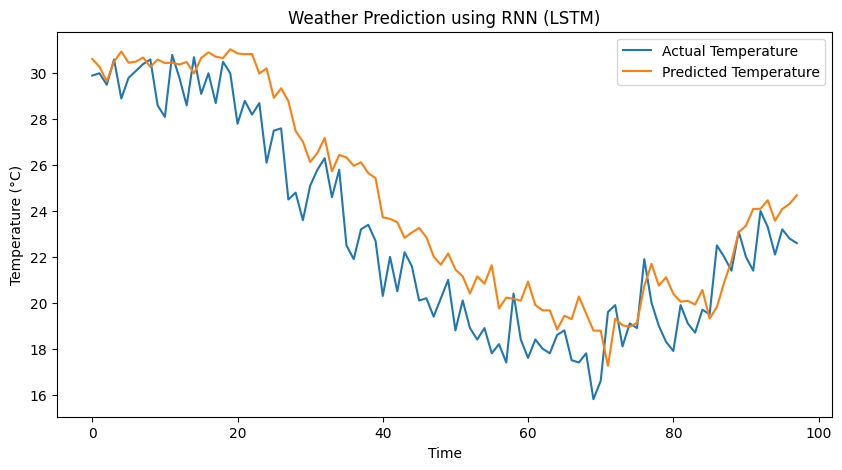

In [158]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label="Actual Temperature")
plt.plot(predictions_actual, label="Predicted Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Weather Prediction using RNN (LSTM)")
plt.legend()
plt.show()

`Step 12: Learning Curve`

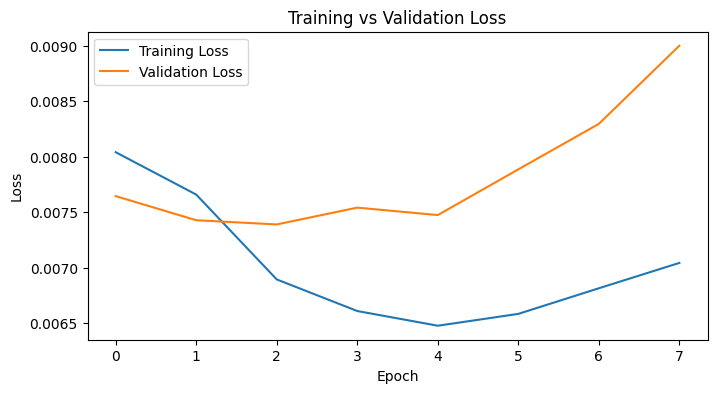

In [159]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()
